In [2]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############

import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [3]:
link_df = pd.read_csv('dist_csvs/income_to_amount_dist_.csv')

In [42]:
#link_df = link_df[link_df.year == 2014].copy()
link_df.income = link_df.income.map(int)
link_df.amount = link_df.amount.map(int)
link_df['mult'] = link_df.amount/link_df.income
link_df.tail()
#link_df.drop(link_df['count.1'], inplace=True)

,year,income,amount,count_income,mult
2216549,2004,9999,9999,1,1.00000
2216550,2004,9999,10000,1,1.00010
2216551,2004,9999,11000,1,1.10011
2216552,2004,9999,12000,1,1.20012
2216553,2004,9999,18000,1,1.80018


In [43]:
df_20to30 = link_df[(link_df['income'] > 20) & (link_df['income'] <= 30)].copy()
#df_20to30 = df_20to30[(df_20to30.amount < max_q) & (df_20to30.amount > min_q) & (df_20to30.year == 2014)]
max_20to30 = link_df.amount[(link_df['income'] > 20) & (link_df['income'] < 30)].max()
min_20to30 = link_df.amount[(link_df['income'] > 20) & (link_df['income'] < 30)].min()

amt_range = max_20to30 - min_20to30

In [55]:

#df_20to30 = df_20to30[(df_20to30.amount <520) & (df_20to30.amount > 10)]
print(df_20to30.amount.std(), 'std')
print(df_20to30.amount.mean(), 'mean')
print(df_20to30.amount.median(), 'median')
print(df_20to30.mult.max(), 'max mult')
print(df_20to30.mult.min(), 'min mult')
print(df_20to30.amount.quantile(q=.98), '98%')
print(df_20to30.amount.quantile(q=.75), 'q3')
print(df_20to30.amount.quantile(q=.25), 'q1')
print(df_20to30.amount.quantile(q=.02), '02%')
q1 = df_20to30.amount.quantile(q=.25)
q3 = df_20to30.amount.quantile(q=.75)
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5*iqr
max_q = q3 + 1.5*iqr
df_20to30.head(40)

583.814801427 std
186.478834356 mean
150.0 median
2347.82608696 max mult
0.0333333333333 min mult
609.02 98%
238.0 q3
76.0 q1
7.0 02%
162.0 iqr


,year,income,amount,count_income,mult
3692,2014,21,1,3,0.047619
3693,2014,21,4,1,0.190476
3694,2014,21,5,5,0.238095
3695,2014,21,6,2,0.285714
3696,2014,21,8,1,0.380952
3697,2014,21,9,3,0.428571
3698,2014,21,10,9,0.476190
3699,2014,21,11,3,0.523810
3700,2014,21,12,7,0.571429
3701,2014,21,13,5,0.619048


In [1]:
#df_20to30 = df_20to30[(df_20to30.amount < max_q) & (df_20to30.amount > min_q) & (df_20to30.year == 2014)]

try:
    df_20to30.sort_values(by=df_20to30.amount,axis=0, inplace=True)
except IndexError as e:
    print(e)
q1 = df_20to30.amount.quantile(q=.25)
q3 = df_20to30.amount.quantile(q=.75)
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5*iqr
max_q = q3 + 1.5*iqr


print(df_20to30.amount.std(), 'std')
print(df_20to30.amount.mean(), 'mean')
print(df_20to30.amount.median(), 'median')
print(df_20to30.amount.max(), 'max', df_20to30.amount.min(), 'min')

print(df_20to30.mult.max(), 'max mult')
print(df_20to30.mult.min(), 'min mult')
print(df_20to30.amount.quantile(q=.98), '98%')
print(df_20to30.amount.quantile(q=.75), '75%')
print(df_20to30.amount.quantile(q=.25), '25%')
print(df_20to30.amount.quantile(q=.02), '02%')
    

NameError: name 'df_20to30' is not defined

In [30]:
line = plt.figure(figsize=(15,12))
y = df_20to30['count_income']
x = df_20to30.amount
plt.plot(x,y)

AttributeError: 'Series' object has no attribute 'sorted'

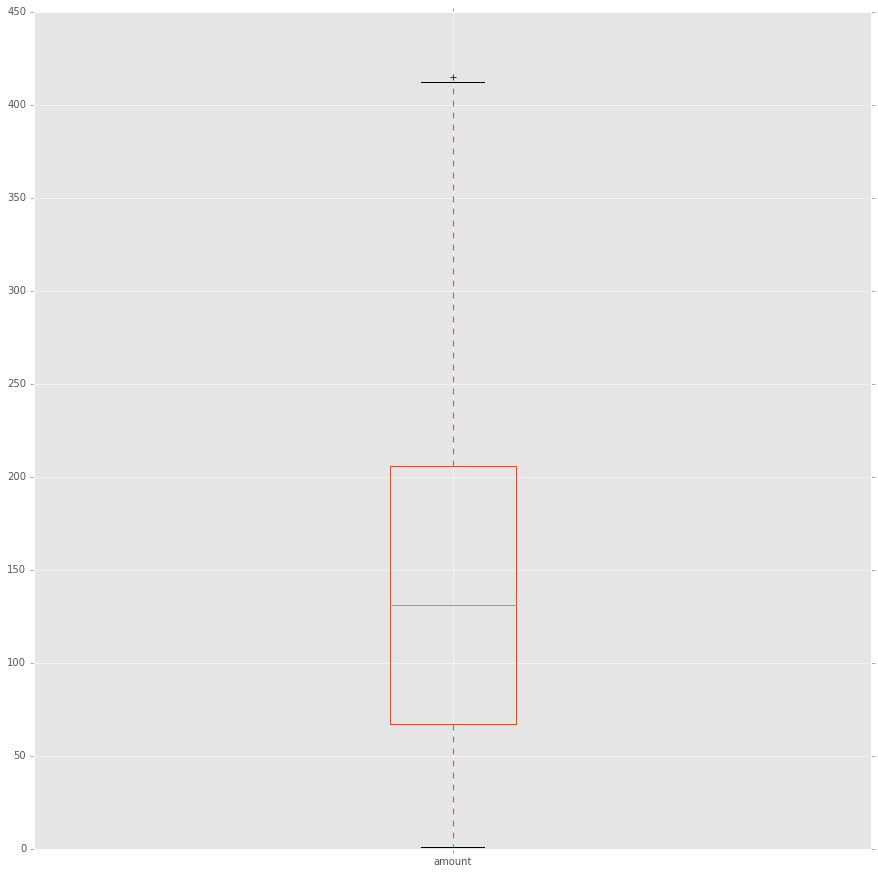

In [22]:
box = plt.figure(figsize=(15,15))
df_20to30.amount.plot(kind='box')
#df_20to30.income.plot(kind='box')

In [9]:
df_30to40 = link_df[(link_df['income'] > 30) & (link_df['income'] <= 40) & (link_df.year ==2014)].copy()
df_30to40 = df_30to40[(df_30to40.amount <350)] #& (df_30to40.amount > 10)] #set min and max reasonable distributions
print(df_30to40.amount.std(), 'std')
print(df_30to40.amount.mean(), 'mean')
print(df_30to40.amount.median(), 'median')
print(df_30to40.mult.max(), 'max mult')
print(df_30to40.mult.min(), 'min mult')
print(df_30to40.amount.quantile(q=.98), '98%')
print(df_30to40.amount.quantile(q=.75), '75%')
print(df_30to40.amount.quantile(q=.25), '25%')
print(df_30to40.amount.quantile(q=.02), '02%')

91.4686073695 std
152.174780257 mean
148.0 median
10.875 max mult
0.025 min mult
330.0 98%
223.0 75%
74.25 25%
6.14 02%


In [23]:
box = plt.figure(figsize=(15,15))
df_30to40.amount.plot(kind='box')

NameError: name 'df_30to40' is not defined

In [24]:
amt = plt.figure(figsize=(15,10))
x = df_30to40.amount
#plt.xticks(np.arange(min(x), max(x)+1, 150))
y = df_30to40['count']

plt.plot(x,y)
plt.show(amt)

NameError: name 'df_30to40' is not defined

In [12]:
df_30to40.tail()

,year,income,amount,count,count.1,mult
10431,2014,40,337,1,1,8.425
10432,2014,40,340,2,2,8.500
10433,2014,40,342,1,1,8.550
10434,2014,40,344,1,1,8.600
10435,2014,40,348,1,1,8.700
